In [1]:
import os
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
from IPython.core.display import *
from IPython.lib.display import *
from matplotlib.colors import LogNorm
from utils.radar_utils import get_crd_data, plot_crd_data, plot_abs_data

DATA_FOLDER = os.path.join("data/")

def subject_samples(subject, experiments=[0, 1, 2]):
    base_paths = [os.path.join(DATA_FOLDER, f"{subject}/{subject}-{exp*5 + pose}_")  for exp in experiments for pose in range(5)]
    return [(f"{b}colour.npy", f"{b}depth.npy") for b in base_paths]

def plot_frames(frames, depth=False):
    for f in frames:
        if depth:
            plt.imshow(f, norm=LogNorm())
        else:
            plt.imshow(f)
            plt.axis('off') 
        display(plt.gcf())
        clear_output(wait=True)

depth_scale = 0.0002500000118743628

# image_timestamps = np.load("data/0/0-0_timestamps.npy")

C:\Users\jovin\AppData\Local\Temp\ipykernel_1736\1039544114.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import *
C:\Users\jovin\AppData\Local\Temp\ipykernel_1736\1039544114.py:6: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import *
C:\Users\jovin\AppData\Local\Temp\ipykernel_1736\1039544114.py:6: DeprecationWarning: Importing publish_display_data from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import *
C:\Users\jovin\AppData\Local\Temp\ipykernel_1736\1039544114.py:6: DeprecationWarning: Importing update_display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import *
C:\Users\jovin\AppData\Local\Te

In [ ]:
subject = 90
experiment = 0

images = (np.load(f"data/{subject}/{subject}-{experiment}_colour.npy")).astype(int)
depths = (np.load("data/0/0-0_depth.npy")).astype(int)
with open(f"data/{subject}/{subject}-{experiment}_radar.json", "r") as radar_json:
    crd_0 = get_crd_data(json.load(radar_json))


plot_frames([images[0]])
plot_crd_data(crd_0[1:4])
# plot_frames(depths, True)

In [2]:
subject = subject_samples("90")
frames = []
for sample in subject:
    frames.append(np.load(os.path.join(sample[0])).astype(int)[0])

frames = np.stack(frames)
plot_frames(frames)

FileNotFoundError: [Errno 2] No such file or directory: 'data/90/90-1_colour.npy'

In [6]:
3e8/(2*5.5e9)

0.02727272727272727

(75, 3, 32, 16)
0


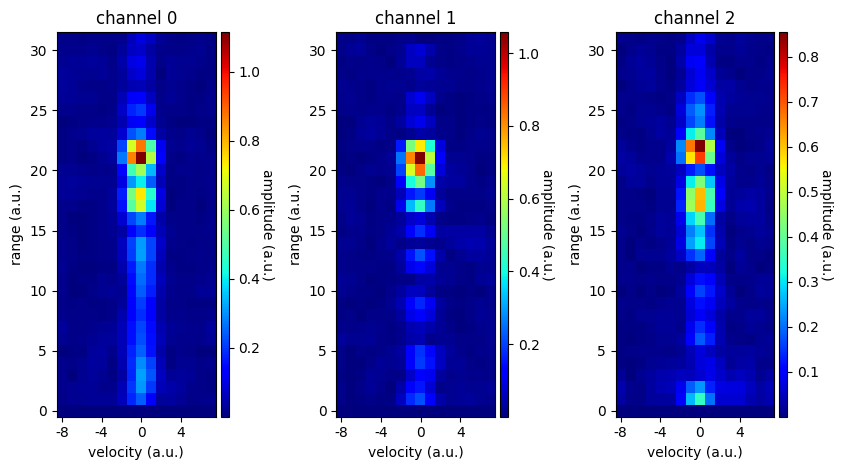

1


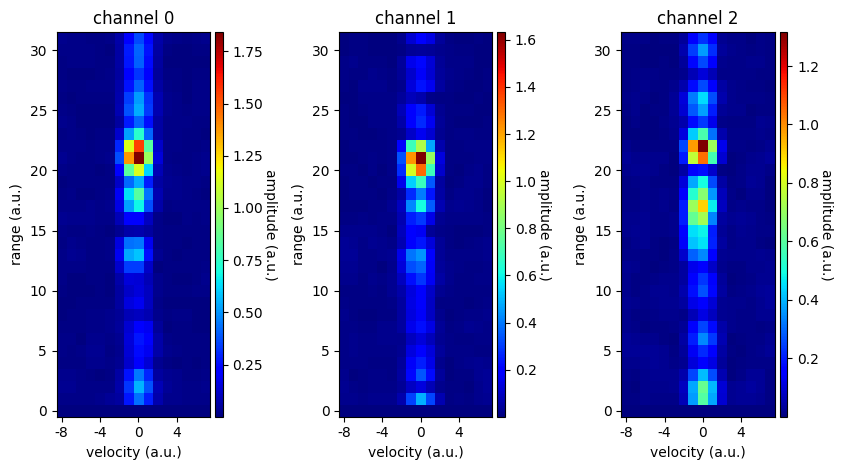

2


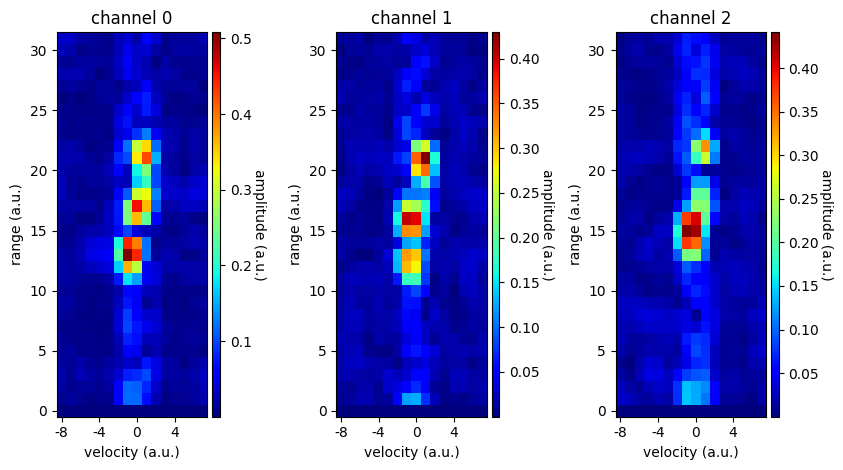

3


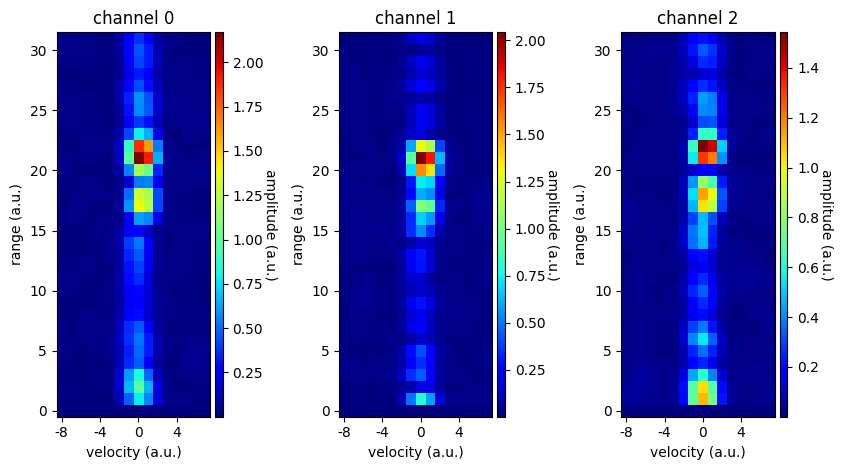

4


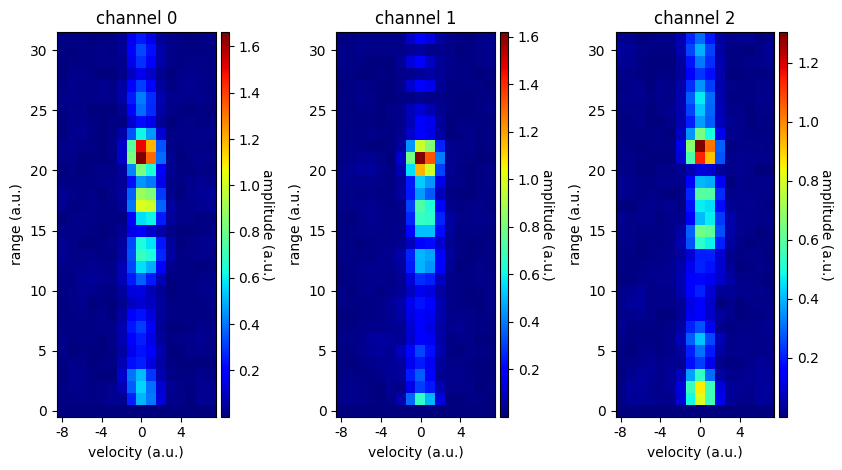

5


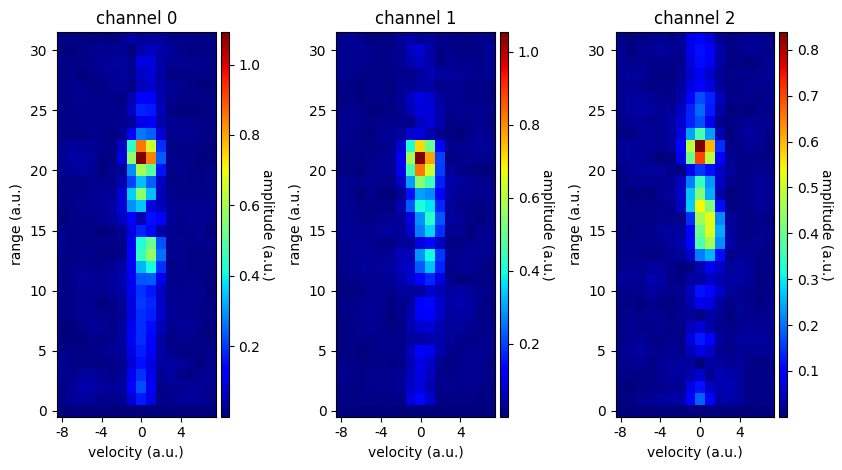

6


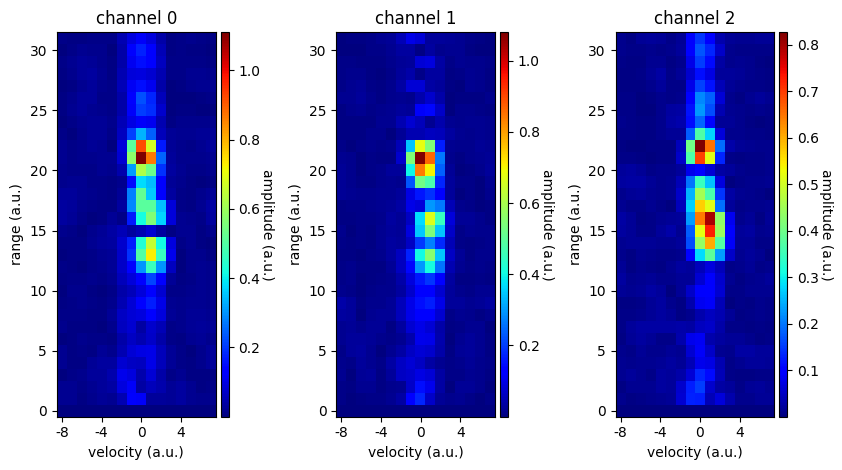

7


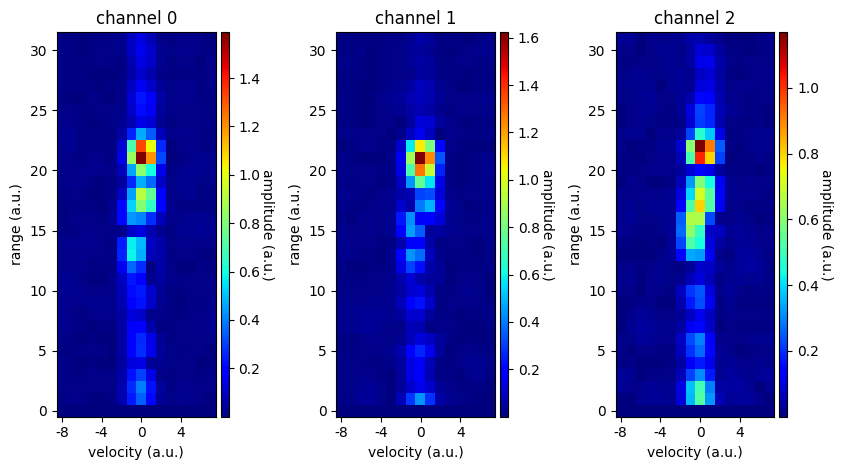

8


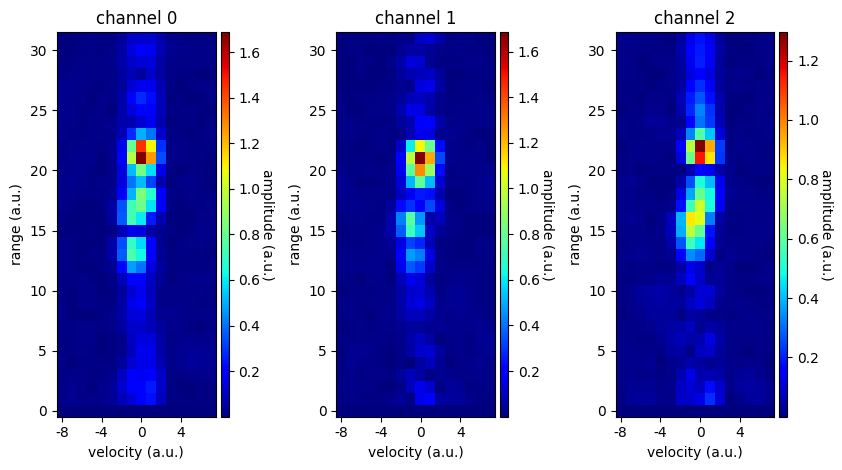

9


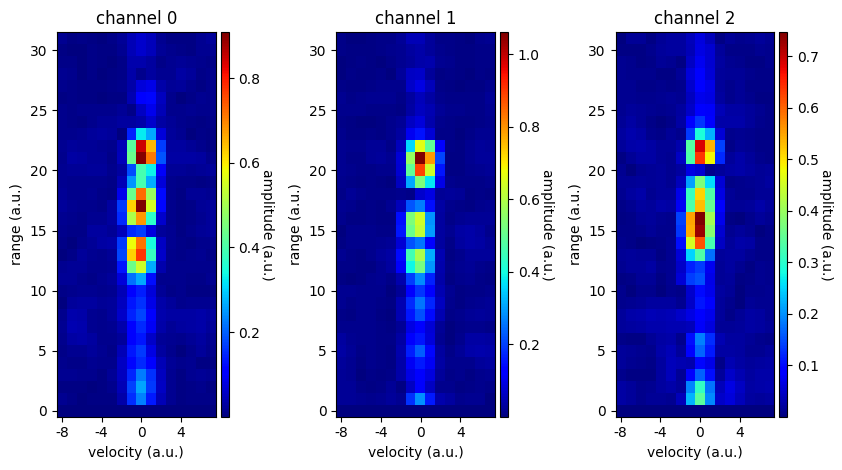

In [11]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def compute_rp_complex(chirp_raw, zpf = 1):
    n_rbins = chirp_raw.shape[0]

    # window
    window = np.blackman(n_rbins).astype(np.float32)
    window /= np.linalg.norm(window)

    chirp_raw = chirp_raw - np.mean(chirp_raw)  
    # range processing
    chirp_raw = chirp_raw.astype(np.float32)
    chirp_raw *= window
    chirp_raw = chirp_raw - np.mean(chirp_raw)
    rp_complex = np.fft.fft(chirp_raw, n=n_rbins * zpf)[:int(n_rbins * zpf / 2)] / n_rbins

    return rp_complex

def get_rp_data(json_data, chirps_per_burst=16):
    rp_data = list()
    for burst in np.asarray(json_data['bursts']):
        chirps_in_burst = np.asarray(burst['chirps']).reshape(chirps_per_burst,3,-1)
        for channels_in_chirp in chirps_in_burst:
            rp_chirp = list()
            for chirp_per_channel in channels_in_chirp:
                chirp = np.asarray(chirp_per_channel)
                rp_chirp.append(compute_rp_complex(chirp))
            rp_data.append(rp_chirp)
    return np.asarray(rp_data)

def remove_clutter(range_data, clutter_alpha):
    assert range_data.ndim == 3
    clutter_map = 0
    nchirp, nchan, szr = range_data.shape
    range_clutter = range_data.copy()
    if clutter_alpha != 0:
        clutter_map = range_data[0]
        for ic in range(1, nchirp):
            clutter_map = (clutter_map * clutter_alpha + range_data[ic, ...] * (1.0 - clutter_alpha))
            range_clutter[ic, ...] -=  clutter_map
    return range_clutter

def get_crd_data(json_data, clutter_coeff=0.9, num_chirps_per_burst=16):
    rp_data = get_rp_data(json_data, num_chirps_per_burst)
    rp_clutter = remove_clutter(rp_data, clutter_coeff)

    window = np.blackman(num_chirps_per_burst).astype(np.float32)
    window /= np.linalg.norm(window)

    rp_transposed = np.transpose(rp_clutter, (1, 0, 2))
    result = []
    for channel_data in rp_transposed:
        channel_data = np.reshape(channel_data, (channel_data.shape[0] // num_chirps_per_burst, num_chirps_per_burst, channel_data.shape[1]))
        crp_per_channel = []
        for burst in channel_data:
            burst = np.transpose(burst)
            crp_burst = []
            for data in burst:
                data = data * window
                data = np.fft.fft(data)
                crp_burst.append(data)
            crp_burst = np.asarray(crp_burst)
            crp_per_channel.append(crp_burst)
        crp_per_channel = np.asarray(crp_per_channel)
        result.append(crp_per_channel)
    result = np.asarray(result)
    result = np.transpose(result,(1, 0, 2, 3))
    result = np.roll(result, result.shape[3]//2, axis=3)
    return result


def plot_crd_data(crd_data, path=""):
    num_channels=crd_data.shape[1]
    for i,frame_crd in enumerate(crd_data):
        print(i)
        # fig,axs=plt.subplots(nrows=1,ncols=3,gridspec_kw={'width_ratios':(1,1,1)},figsize = (20, 2), dpi=200)
        fig,axs=plt.subplots(nrows=1,ncols=3,gridspec_kw={'width_ratios':(1,1,1)},figsize = (8.53,4.8), dpi=100)
        for channel_id in range(num_channels):  
            # plt.subplot(1, num_channels, channel_id + 1,sharey=True)
            im = axs[channel_id].imshow(np.abs(frame_crd[channel_id,:,:]), origin='lower', cmap=plt.get_cmap('jet'), interpolation='none', aspect='auto')
            axs[channel_id].set_title("channel " + str(channel_id))
            axs[channel_id].set_xlabel('velocity (a.u.)')
            axs[channel_id].set_xticks(ticks = [0,4,8,12])
            # axs[channel_id].set_xticks(ticks = range(0, 64, 16))
            axs[channel_id].set_xticklabels(labels=(-8,-4,0,4))
            divider = make_axes_locatable(axs[channel_id])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(im,cax=cax)
            cbar.set_label('amplitude (a.u.)',rotation=270,labelpad=10)
            axs[channel_id].set_ylabel('range (a.u.)')

        plt.tight_layout()
        plt.grid(False)
        # plt.savefig(r"{}/img{}.png".format(path,i))
        plt.show()
        # plt.close()

subject = 91
experiment = 10
with open(f"data/{subject}/{subject}-{experiment}_radar.json", "r") as radar_json:
    radar = json.load(radar_json)

# ? Bursts x 64 Chirps x 3 Channels x 16 Samples
# num_chirps_per_burst=64:
# 252 Frames x 3 Channels x 8 Range-Profile (RP) Bins x 64 Doppler Bins
# num_chirps_per_burst=16:
# 252 Frames x 3 Channels x 32 Range-Profile (RP) Bins x 16 Doppler Bins
crd_data = get_crd_data(radar, num_chirps_per_burst=16)
print(crd_data.shape)
plot_crd_data(crd_data[:10])

# crd_reshaped = np.abs(np.einsum("fcrd->frdc", crd_data))
# print(crd_reshaped.shape)
# for i in range(10):
#     plt.figure()
#     plt.imshow(crd_reshaped[i]*20, cmap=plt.get_cmap('jet'))

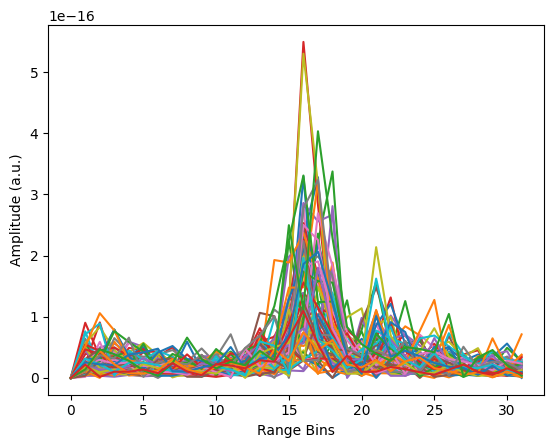

In [18]:
# plt.plot(np.abs(np.sum(crd_data[3], axis=2))[0])
# plt.plot(np.abs(np.sum(crd_data[3], axis=2))[1])
# plt.plot(np.abs(np.sum(crd_data[3], axis=2))[2])
abs_range = np.abs(np.sum(np.sum(crd_data[1:], axis=3), axis=1))
print(abs_range.shape)
for frame in abs_range:
    plt.plot(frame)
    plt.xlabel("Range Bins")
    plt.ylabel("Amplitude (a.u.)")
    display(plt.gcf())
    clear_output(wait=True)